In [116]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import LSTM, Bidirectional, Dropout, Embedding
from keras.models import Model, load_model
import keras.metrics 
from keras import callbacks # for early stoppubg
from tensorflow.keras.optimizers import Adam  # note add tensorflow
from sklearn.metrics import roc_auc_score  # for evaluating classifier
import tensorflow as tf # for metrics 


In [86]:
# load data
file_path = './datafiles/blindPosts/'
files = [file_path + f for f in os.listdir(file_path)]
df = pd.concat([pd.read_csv(f, parse_dates=True).iloc[:, 1:]
                for f in files])
df = df.set_index('company')

# change data type
df = df.rename({'post_like': 'likes', 'post_comment': 'comments'}, axis=1)
df['post_firm'] = df['post_firm'].map(lambda x: str(x).replace('/company/', '').rstrip('/'))
df['likes'] = df['likes'].map(lambda x: str(x).replace(',', ''))
df['comments'] = df['comments'].map(lambda x: str(x).replace(',', ''))
df['likes'] = pd.to_numeric(df['likes'])
df['comments'] = pd.to_numeric(df['comments'])
df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])
df = df.reset_index().set_index(
    ['company', 'post_timestamp']).sort_index().reset_index()

# let's generate labels popular and controversial based on likes and comments 
df[~df['post_text'].duplicated()]
df['popular'] = np.where(df['likes'] > df['likes'].quantile(0.99), 1, 0)
df['controversial'] = np.where(df['comments'] > df['comments'].quantile(0.99), 1, 0)
data = df[['post_text', 'post_firm', 'popular', 'controversial']] # keep poster company if available

In [87]:
# imbalanced data correction
# examine imbalance
neg, pos = np.bincount(df['popular'])
total = neg + pos
INITIAL_BIAS = np.log([pos/neg])
print("Positive rate:", round(pos/total*100,3), '%')
# class weights
# scaling by total/2 helps keep the loss to a similar magnitude.
# the sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Positive rate: 0.99 %
Weight for class 0: 0.51
Weight for class 1: 50.49


In [88]:
MAX_SEQUENCE_LENGTH = 400
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 2048  # make sure each batch has chance of obtaining positive examples
EPOCHS = 100
EARLY_STOPPING = callbacks.EarlyStopping(monitor="val_loss",
                                         mode="min", patience=5,
                                         restore_best_weights=True)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [91]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./datafiles/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

# prepare text samples and their labels
print('Loading in comments')
train = data
sentences = train['post_text'].fillna('DUMMY_VALUE').values
possible_labels = ['controversial', 'popular']
targets = train[possible_labels].values  # N * 2 matrix

s = sorted(len(s) for s in sentences)
print("median sequence length: ", s[len(s)//2])
print("max sequence length: ", s[-1])
print("min sequence length: ", s[0])
# convert the sentences (strings) to ints
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print(sequences[0])
# get word -> int mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
# pad sequences so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)


Loading word vectors...
Found 400000 word vectors.
Loading in comments
median sequence length:  276
max sequence length:  24302
min sequence length:  1
Found 134858 unique tokens.
Shape of data tensor:  (241157, 400)


In [92]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,  # keep the embeddings fixed
)
print('Building model...')
# train a lstm network with a single lstm
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x) 


Filling pre-trained embeddings...
Building model...


In [ ]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics= METRICS # accuracy is not good for this task 
)


print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight = CLASS_WEIGHT,
    callbacks = [EARLY_STOPPING]
)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


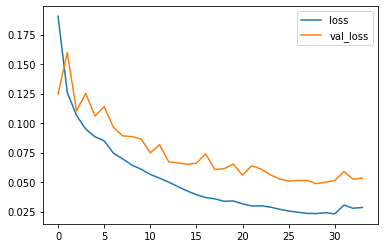

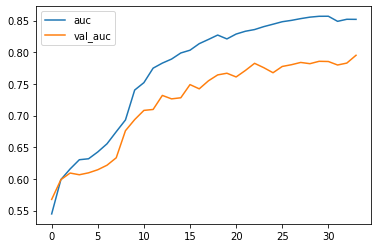

In [100]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# plot some data
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

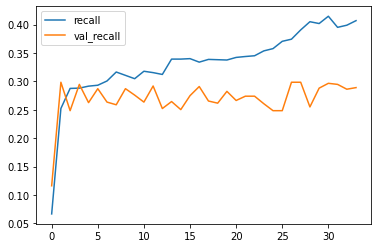

In [108]:
# plot some data
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.legend()
plt.show()

True Negatives:  tf.Tensor(237869, shape=(), dtype=int32)
False Positives:  tf.Tensor(900, shape=(), dtype=int32)
False Negatives:  tf.Tensor(1037, shape=(), dtype=int32)
True Positives:  tf.Tensor(1351, shape=(), dtype=int32)
Total Positive:  2388


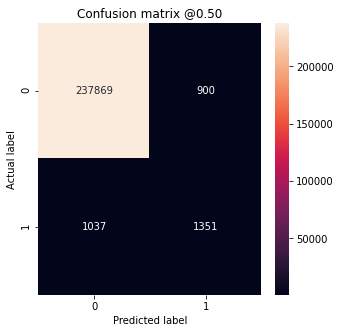

In [123]:

def plot_cm(labels, predictions, p=0.5):
  cm = tf.math.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Positive: ', np.sum(cm[1]))

p = model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 

In [122]:
# save model
model.save('./model/blind_lstm')

INFO:tensorflow:Assets written to: ./model/blind_lstm/assets


INFO:tensorflow:Assets written to: ./model/blind_lstm/assets
